In [1]:
import datetime as dt
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from pandas_datareader import data as pdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from jacobian import Lyapunov

C:\Users\Francesco\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Francesco\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Francesco\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Francesco\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

ModuleNotFoundError: No module named 'pandas_datareader'

In [ ]:
def get_data_from_yahoo(ticker):
    if not os.path.exists('stocks_dfs') :
        os.makedirs('stocks_dfs')

    start = dt.datetime(2010, 1, 1)
    end = dt.datetime(2020, 3, 20)

    if not os.path.exists('stocks_dfs/{}.pkl'.format(ticker)):
        df = pdr.get_data_yahoo(ticker, start, end)
        df.to_pickle('stocks_dfs/{}.pkl'.format(ticker))
    else:
        print('Already have {}'.format(ticker))

In [ ]:
get_data_from_yahoo('GOOG')

In [ ]:
df = pd.read_pickle('stocks_dfs/GOOG.pkl')
df.index = np.arange(len(df))
df

In [2]:
close = df.Close
plt.plot(close)

NameError: name 'df' is not defined

In [186]:
# Dimensionality parameters
L = 1   # step granularity
m = 10  # window size
q = 64  # number of neurons

In [187]:
def sliding_window(df, m, L): 
    slid_w = []
    targets = []
    for i,row in df.iterrows():
        if i + m*L < len(df.index):
            slid_w.append(list(df.loc[i:i+L*m-1:L,'Close']))
            targets.append(df.loc[i+m*L,'Close'])
    data = pd.DataFrame(slid_w)
    return data,targets

X, y = sliding_window(df, m, L)
y = pd.DataFrame(y, columns = ['target'])

In [188]:
scaler = StandardScaler()
scaler.fit(pd.concat([X, y]))
X = pd.DataFrame(scaler.transform(pd.concat([X, y], axis = 1)))

In [189]:
y = X.loc[:,10]
X = X.loc[:,:9]

In [190]:
model = Sequential([
  Dense(q, activation='tanh', input_shape=(m,)),  
  Dense(1),
])

model.compile(
  optimizer='adam',
  loss='mean_squared_error',
  metrics=['mse','mae'],
)

model.fit(X, np.asarray(y), epochs=1000, verbose = False, batch_size = 16)
model.evaluate(X, np.asarray(y))

81/81 [==============================] - 0s 525us/step - loss: 0.0012 - mse: 0.0012 - mae: 0.0213  


[0.0012034628307446837, 0.0012034628307446837, 0.02130170725286007]

In [191]:
y_predict = pd.DataFrame(model.predict(X).reshape(1,-1)).T
y_predict.columns = ['target']
new_X = pd.concat([X, y_predict], axis = 1)
new_X = pd.DataFrame(scaler.inverse_transform(new_X))
new_y = new_X[m]

In [192]:
new_close = close[m:]
new_close.index = range(len(new_y))

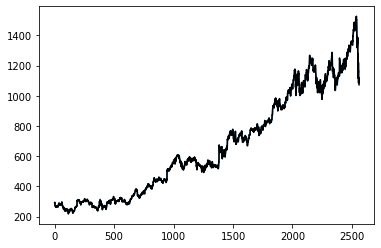

In [196]:
plt.plot(new_y[0:])
plt.plot(new_close[0:], c = 'black')

In [194]:
weights = model.get_weights()
## dai i pesi della NN a lyapunov -> coefficiente di lyap 
weights

[array([[-1.33341610e-01,  8.00150186e-02,  1.61825027e-02,
         -3.29817176e-01,  5.96077383e-01, -1.95204020e-01,
          4.18845236e-01, -2.76185185e-01, -4.22537737e-02,
         -3.48812789e-02, -1.71336800e-01,  3.76654677e-02,
         -3.15386117e-01,  1.39530927e-01,  7.30381459e-02,
          3.65718335e-01,  3.46180111e-01,  9.72696245e-02,
         -1.24680854e-01, -2.69482523e-01, -5.85543178e-02,
          1.56796888e-01,  1.26799911e-01,  8.61751363e-02,
          4.87438636e-04,  5.64324223e-02, -5.54163195e-02,
          1.26806917e-02, -1.20824657e-01,  1.27499541e-02,
          2.06626445e-01,  5.13793528e-03,  1.03672750e-01,
          2.06487142e-02,  3.40897441e-02, -1.24983743e-01,
          1.40495881e-01, -1.66207254e-01,  5.13592176e-02,
          7.11364970e-02,  1.42741978e-01,  6.93711936e-02,
         -1.70861155e-01,  1.81608111e-01,  2.22473845e-01,
          1.97305694e-01, -1.81004182e-01,  1.35621101e-01,
         -4.32620287e-01,  9.52015668e-0

In [195]:
weights = model.get_weights()
weights = [model.layers[1].get_weights()[1], model.layers[0].get_weights()[0]]
model.layers[1].get_weights()[0]

NameError: name 'alpha' is not defined

In [ ]:
T=1500
x=new_y[0:]/1000
a=model.layers[1].get_weights()[0]
b=model.layers[0].get_weights()[0]
bi=model.layers[0].get_weights()[1]
l=Lyapunov (a,b,bi,x,L,m,q,T)
print(l)